In [1]:
import logging
import os
from datetime import datetime
from importlib.metadata import version
from pathlib import Path
from typing import Annotated, Dict, List, Optional, cast

import huggingface_hub
import typer
from datasets import Dataset, load_dataset
from dotenv import load_dotenv

from vidore_benchmark.compression.token_pooling import HierarchicalEmbeddingPooler
from vidore_benchmark.evaluation.evaluate import evaluate_dataset
from vidore_benchmark.evaluation.interfaces import MetadataModel, ViDoReBenchmarkResults
from vidore_benchmark.retrievers.registry_utils import load_vision_retriever_from_registry
from vidore_benchmark.utils.logging_utils import setup_logging

/home/t-jiaweiwang/miniconda3/envs/ColPali/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_class = "colqwen2"
pretrained_model_name_or_path = None
retriever = load_vision_retriever_from_registry(
    model_class,
    pretrained_model_name_or_path=pretrained_model_name_or_path,
)

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Loaded custom processor.



In [3]:
dataset_name = "vidore/tatdqa_test"
split = "test"

dataset = cast(Dataset, load_dataset(dataset_name, split=split))

In [4]:
from __future__ import annotations

import math
from typing import Any, Dict, List, Optional

import torch
from datasets import Dataset
from tqdm import tqdm

from vidore_benchmark.compression.token_pooling import BaseEmbeddingPooler
from vidore_benchmark.retrievers.bm25_retriever import BM25Retriever
from vidore_benchmark.retrievers.vision_retriever import VisionRetriever
from vidore_benchmark.utils.iter_utils import batched


def evaluate_dataset(
    vision_retriever: VisionRetriever,
    ds: Dataset,
    batch_query: int,
    batch_passage: int,
    batch_score: Optional[int] = None,
    embedding_pooler: Optional[BaseEmbeddingPooler] = None,
) -> Dict[str, Optional[float]]:
    """
    Evaluate the model on a given dataset using the MTEB metrics.

    NOTE: The dataset should contain the following columns:
    - query: the query text
    - image_filename: the filename of the image
    - image: the image (PIL.Image) if `use_visual_embedding` is True
    - text_description: the text description (i.e. the page caption or the text chunks) if
        `use_visual_embedding` is False
    """

    # Dataset: sanity check
    passage_column_name = "image" if vision_retriever.use_visual_embedding else "text_description"
    required_columns = ["query", passage_column_name, "image_filename"]

    if not all(col in ds.column_names for col in required_columns):
        raise ValueError(f"Dataset should contain the following columns: {required_columns}")

    # Remove `None` queries (i.e. pages for which no question was generated) and duplicates
    # queries = list(set(ds["query"]))
    # --> old buggy behavior - this differs from colpali-engine implementation where duplicates are NOT removed
    # for fairness with externally evaluated retrievers since bug, we maintain this behavior and remove duplicates
    # This slightly boosts scores on docvqa typically
    seen_queries = set()
    queries = []
    for query in ds["query"]:
        if query is not None and query not in seen_queries:
            queries.append(query)
            seen_queries.add(query)

    if len(queries) == 0:
        raise ValueError("All queries are None")

    # Edge case: using the BM25Retriever
    if isinstance(vision_retriever, BM25Retriever):
        passages = ds[passage_column_name]
        scores = vision_retriever.get_scores_bm25(queries=queries, passages=passages)
        relevant_docs, results = vision_retriever.get_relevant_docs_results(ds, queries, scores)
        metrics = vision_retriever.compute_metrics(relevant_docs, results)
        return metrics

    # Get the embeddings for the queries and passages
    emb_queries = vision_retriever.forward_queries(queries, batch_size=batch_query)

    # NOTE: To prevent overloading the RAM for large datasets, we will load the passages (images)
    # that will be fed to the model in batches (this should be fine for queries as their memory footprint
    # is negligible. This optimization is about efficient data loading, and is not related to the model's
    # forward pass which is also batched.
    emb_passages: List[torch.Tensor] = []

    dataloader_prebatch_size = 10 * batch_passage

    for passage_batch in tqdm(
        batched(ds, n=dataloader_prebatch_size),
        desc="Dataloader pre-batching",
        total=math.ceil(len(ds) / (dataloader_prebatch_size)),
    ):
        passages: List[Any] = [db[passage_column_name] for db in passage_batch]
        batch_emb_passages = vision_retriever.forward_passages(passages, batch_size=batch_passage)
        if isinstance(batch_emb_passages, torch.Tensor):
            batch_emb_passages = list(torch.unbind(batch_emb_passages))
            emb_passages.extend(batch_emb_passages)
        else:
            emb_passages.extend(batch_emb_passages)

    if embedding_pooler is not None:
        for idx, emb_document in tqdm(enumerate(emb_passages), total=len(emb_passages), desc="Pooling embeddings..."):
            emb_document, _ = embedding_pooler.pool_embeddings(emb_document)
            emb_passages[idx] = emb_document

    # Get the similarity scores
    scores = vision_retriever.get_scores(emb_queries, emb_passages, batch_size=batch_score)

    # Get the relevant passages and results
    relevant_docs, results = vision_retriever.get_relevant_docs_results(ds, queries, scores)

    # Compute the MTEB metrics
    metrics = vision_retriever.compute_metrics(relevant_docs, results)

    return metrics

In [ ]:
evaluate_dataset(
    retriever,
    dataset,
    batch_query=8,
    batch_passage=8,
    batch_score=16,
    embedding_pooler=None,
)

Dataloader pre-batching: 100%|██████████| 21/21 [04:39<00:00, 13.29s/it]  


In [5]:
"""
Evaluate the model on a given dataset using the MTEB metrics.

NOTE: The dataset should contain the following columns:
- query: the query text
- image_filename: the filename of the image
- image: the image (PIL.Image) if `use_visual_embedding` is True
- text_description: the text description (i.e. the page caption or the text chunks) if
    `use_visual_embedding` is False
"""
vision_retriever = retriever
ds = dataset
batch_query = 8
batch_passage = 8
batch_score = 16
embedding_pooler = None

# Dataset: sanity check
passage_column_name = "image" if vision_retriever.use_visual_embedding else "text_description"
required_columns = ["query", passage_column_name, "image_filename"]

if not all(col in ds.column_names for col in required_columns):
    raise ValueError(f"Dataset should contain the following columns: {required_columns}")

# Remove `None` queries (i.e. pages for which no question was generated) and duplicates
# queries = list(set(ds["query"]))
# --> old buggy behavior - this differs from colpali-engine implementation where duplicates are NOT removed
# for fairness with externally evaluated retrievers since bug, we maintain this behavior and remove duplicates
# This slightly boosts scores on docvqa typically
seen_queries = set()
queries = []
for query in ds["query"]:
    if query is not None and query not in seen_queries:
        queries.append(query)
        seen_queries.add(query)

if len(queries) == 0:
    raise ValueError("All queries are None")

# Get the embeddings for the queries and passages
emb_queries = vision_retriever.forward_queries(queries, batch_size=batch_query)

# NOTE: To prevent overloading the RAM for large datasets, we will load the passages (images)
# that will be fed to the model in batches (this should be fine for queries as their memory footprint
# is negligible. This optimization is about efficient data loading, and is not related to the model's
# forward pass which is also batched.
emb_passages: List[torch.Tensor] = []

dataloader_prebatch_size = 10 * batch_passage

for passage_batch in tqdm(
    batched(ds, n=dataloader_prebatch_size),
    desc="Dataloader pre-batching",
    total=math.ceil(len(ds) / (dataloader_prebatch_size)),
):
    passages: List[Any] = [db[passage_column_name] for db in passage_batch]
    batch_emb_passages = vision_retriever.forward_passages(passages, batch_size=batch_passage)
    if isinstance(batch_emb_passages, torch.Tensor):
        batch_emb_passages = list(torch.unbind(batch_emb_passages))
        emb_passages.extend(batch_emb_passages)
    else:
        emb_passages.extend(batch_emb_passages)


Dataloader pre-batching: 100%|██████████| 21/21 [04:32<00:00, 12.98s/it]  


In [26]:
scores = vision_retriever.get_scores(emb_queries[1:10], emb_passages, batch_size=batch_score)
scores

tensor([[18.3750, 18.3750, 18.3750,  ..., 10.0625, 10.0625, 10.0625],
        [16.8750, 16.8750, 16.8750,  ..., 10.8750, 10.8750, 10.8750],
        [21.8750, 21.8750, 21.8750,  ..., 12.6875, 12.6875, 12.6875],
        ...,
        [ 7.0312,  7.0312,  7.0312,  ...,  8.8750,  8.8750,  8.8750],
        [10.0625, 10.0625, 10.0625,  ..., 10.3125, 10.3125, 10.3125],
        [15.8750, 15.8750, 15.8750,  ..., 15.0000, 15.0000, 15.0000]])

In [27]:
relevant_docs, results = vision_retriever.get_relevant_docs_results(ds, queries[1:10], scores)

In [18]:
len(results[queries[0]].keys())

277

In [32]:
for key in relevant_docs.keys():
    relevant_doc = {key: relevant_docs[key]}
    results_doc = {key: results[key]}
    metrics = vision_retriever.compute_metrics(relevant_doc, results_doc)
    print(metrics)

{'ndcg_at_1': 1.0, 'ndcg_at_3': 1.0, 'ndcg_at_5': 1.0, 'ndcg_at_10': 1.0, 'ndcg_at_20': 1.0, 'ndcg_at_50': 1.0, 'ndcg_at_100': 1.0, 'map_at_1': 1.0, 'map_at_3': 1.0, 'map_at_5': 1.0, 'map_at_10': 1.0, 'map_at_20': 1.0, 'map_at_50': 1.0, 'map_at_100': 1.0, 'recall_at_1': 1.0, 'recall_at_3': 1.0, 'recall_at_5': 1.0, 'recall_at_10': 1.0, 'recall_at_20': 1.0, 'recall_at_50': 1.0, 'recall_at_100': 1.0, 'precision_at_1': 1.0, 'precision_at_3': 0.33333, 'precision_at_5': 0.2, 'precision_at_10': 0.1, 'precision_at_20': 0.05, 'precision_at_50': 0.02, 'precision_at_100': 0.01, 'mrr_at_1': 1.0, 'mrr_at_3': 1.0, 'mrr_at_5': 1.0, 'mrr_at_10': 1.0, 'mrr_at_20': 1.0, 'mrr_at_50': 1.0, 'mrr_at_100': 1.0, 'naucs_at_1_max': nan, 'naucs_at_1_std': nan, 'naucs_at_1_diff1': nan, 'naucs_at_3_max': nan, 'naucs_at_3_std': nan, 'naucs_at_3_diff1': nan, 'naucs_at_5_max': nan, 'naucs_at_5_std': nan, 'naucs_at_5_diff1': nan, 'naucs_at_10_max': nan, 'naucs_at_10_std': nan, 'naucs_at_10_diff1': nan, 'naucs_at_20_ma

In [34]:
relevant_docs[ds[3]['query']]

{'data/downloaded_datasets/tatdqa/test/637fab7088ea6c78a5dba55f17e833bd.pdf': 1}

In [45]:
ds['image_filename'].index('data/downloaded_datasets/tatdqa/test/a38d13377f754ca4beb5ed5cc9b5c1ec.pdf')

367

In [54]:
for q in ds['query']:
    print(q)

What was the total assets from AMER in 2018?
What was the total assets from APAC in 2019?
What was the total assets in 2018?
How many years did total assets exceed $2,000,000 thousand?
What was the change in the total assets from APAC between 2018 and 2019?
What was the percentage change in the total assets from Corporate and eliminations between 2018 and 2019?
What are the two license agreements for the currently marketed products?
When is revenue recognized?
What are the two forms of revenue generated from contracts with customers?
What is the decrease in licensing revenue from Zyla (Oxaydo) from 2018 to 2019?
How much did the total licensing revenue decreased from 2018 to 2019?
What percentage of the decrease in total revenue is from the loss in Zyla (Oxaydo)?
Which years does the table provide information for the related party items included in Revenues?
What were the software services in 2019?
What were the data and analytic services in 2017?
What was the change in software servic

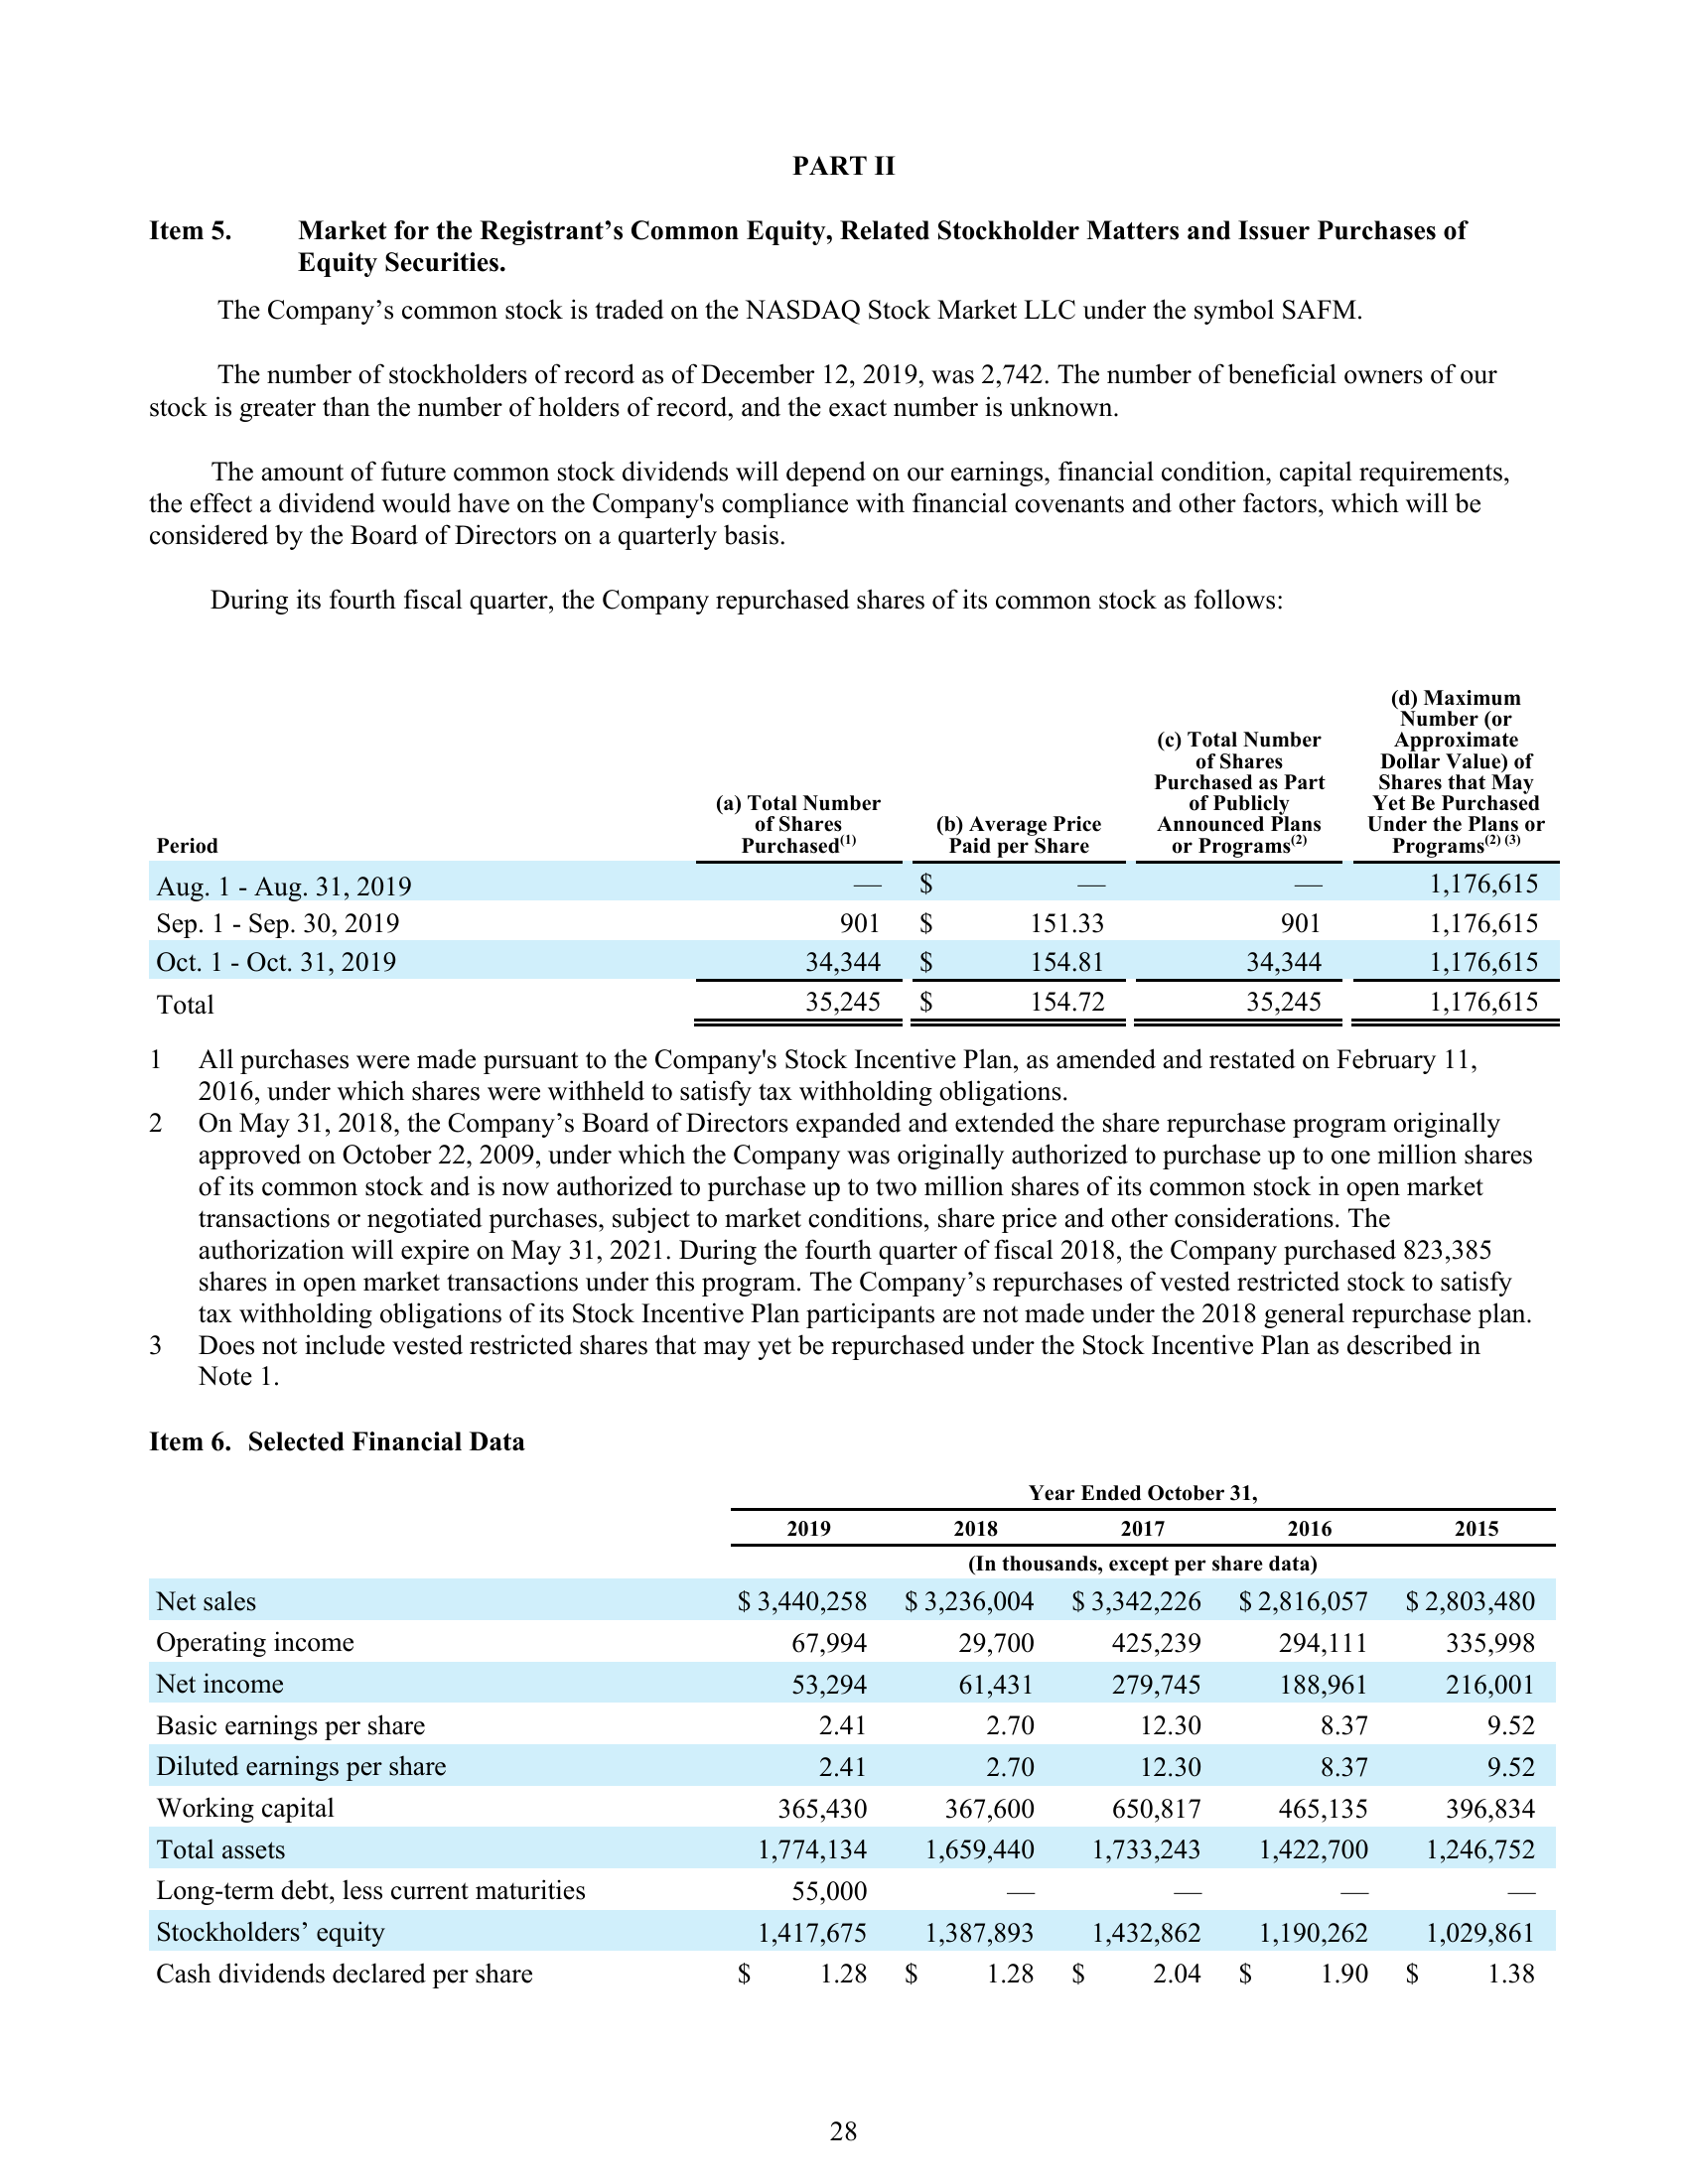

In [47]:
ds[367]['image']